In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import re
import time
# import datetime
from datetime import datetime, timedelta


%matplotlib inline

### Reading initial dataset

In [2]:
df_train = pd.read_csv('../input/kuzushiji-recognition/train.csv')
unicode_map = {codepoint: char for codepoint, char in 
               pd.read_csv('../input/kuzushiji-recognition/unicode_translation.csv').values}

### A bit of statistics

In [3]:
def convert_labels_set(labels_str):
    labels = []
    for one_label_str in re.findall(r'U\+\S+\s\S+\s\S+\s\S+\s\S+', labels_str):
        charcode, x, y, w, h = one_label_str.split(' ')
        labels.append([charcode, int(x), int(y), int(w), int(h)])
    return labels

In [4]:
n_labels = 0
chars_counts = {}

for labels_set in df_train.values[:, 1]:
    if type(labels_set) is not str:
        continue

    labels = convert_labels_set(labels_set)
    n_labels += len(labels)
    for label in labels:
        try:
            chars_counts[label[0]] += 1
        except KeyError:
            chars_counts.update({label[0]: 1})

chars_counts_list = [chars_counts[k] for k in chars_counts]
n_classes = len([k for k in chars_counts])

print('Number of labels:                  {}'.format(n_labels))
print('Number of classes:                 {}'.format(n_classes))
print('Min max number of items per class: {} {}'.format(np.min(chars_counts_list), np.max(chars_counts_list)))
print('Median number of items per class:  {}'.format(np.median(chars_counts_list)))
print('Mean number of items per class:    {}'.format(np.mean(chars_counts_list)))

Number of labels:                  683464
Number of classes:                 4212
Min max number of items per class: 1 24685
Median number of items per class:  9.0
Mean number of items per class:    162.26590693257359


### Making dataset

In [5]:
def get_char_images_from_sheet(src_image_path, labels_str, blur_kernel_size=3, img_size=64):
    src_img = cv2.imread(src_image_path, cv2.IMREAD_COLOR)

    char_imgs, labels_codes = [], []
    for label in convert_labels_set(labels_str):
        char_img = np.zeros((img_size, img_size), dtype=np.uint8)
        charcode, x, y, w, h = label

        label_img = src_img[y:y + h, x:x + w, :]
        label_img = cv2.GaussianBlur(label_img, 
                                     (blur_kernel_size, blur_kernel_size), 
                                     cv2.BORDER_DEFAULT)
        label_img = cv2.cvtColor(label_img, cv2.COLOR_RGB2GRAY)
        _, label_img = cv2.threshold(label_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        label_img = 255 - label_img
        
        if w > h:
            label_img = cv2.resize(label_img, (img_size, int(img_size * h / w)))
            dy = int((img_size - int(img_size * h / w)) / 2)
            char_img[dy:dy + int(img_size * h / w), :] += label_img
        
        else:
            label_img = cv2.resize(label_img, (int(img_size * w / h), img_size))            
            dx = int((img_size - int(img_size * w / h)) / 2)
            char_img[:, dx:dx + int(img_size * w / h)] += label_img
        
        char_imgs.append(char_img)
        labels_codes.append(charcode)
    return char_imgs, labels_codes

In [6]:
img_size = 64
generator_out_depth = 64

chars_imgs = []
chars_labels = []

for value in df_train.values:
    img_filename, labels_str = value
    try:
        imgs, labels = get_char_images_from_sheet('../input/kuzushiji-recognition/train_images/{}.jpg'.format(img_filename), labels_str, img_size=img_size)
    except TypeError:
#         print('Unable to parse {}'.format(labels_str))
        continue
#     imgs = [(image - 127.5).astype('float32') / 127.5 for image in imgs]
#     imgs = [image.reshape(img_size, img_size, 1) for image in imgs]
    chars_imgs.extend(imgs)
    chars_labels.extend(labels)

In [7]:
chars_imgs = np.array(chars_imgs)
np.min(chars_imgs), np.max(chars_imgs), chars_imgs.shape

(0, 255, (683464, 64, 64))

### DCGAN: The simplest example

In [11]:
from tensorflow.keras import layers
import tensorflow as tf

In [60]:
generator_out_depth = 16
discriminator_in_depth = 16

#### Generator

In [53]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense((img_size / 4) * (img_size / 4) * generator_out_depth * 4, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU()) 
    model.add(layers.Reshape((int(img_size / 4), int(img_size / 4), generator_out_depth * 4)))
    assert model.output_shape == (None, img_size / 4, img_size / 4, generator_out_depth * 4) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(generator_out_depth * 2, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, img_size / 4, img_size / 4, generator_out_depth * 2)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(generator_out_depth, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, img_size / 2, img_size / 2, generator_out_depth)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, img_size, img_size, 1)

    return model

(None, 16, 16, 32) (None, 16.0, 16.0, 32)


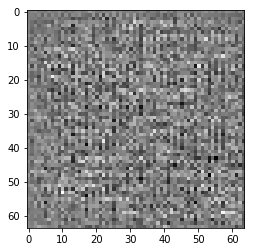

In [54]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Discriminator

In [61]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(discriminator_in_depth, (5, 5), strides=(2, 2), padding='same', input_shape=[img_size, img_size, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(discriminator_in_depth * 2, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [62]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00880086]], shape=(1, 1), dtype=float32)


## Losses

In [63]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [64]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimisers

In [116]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Training loop

In [122]:
EPOCHS = 10
BUFFER_SIZE = 60000
BATCH_SIZE = 2048

noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [125]:
def convert_images_to_tf(images):
    out_images = (images - 127.5).astype('float32') / 127.5
    out_images = out_images.reshape(images.shape[0], img_size, img_size, 1)
    return out_images

In [126]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [128]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

    
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for _ in range(int(dataset.shape[0] / BATCH_SIZE)):
        image_batch = dataset[np.random.choice(range(dataset.shape[0]), BATCH_SIZE)]
        converted_images = convert_images_to_tf(image_batch)
        train_step(converted_images)

    # Produce images for the GIF as we go
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  generate_and_save_images(generator, epochs, seed)

### Training

In [ ]:
train_dataset = chars_imgs

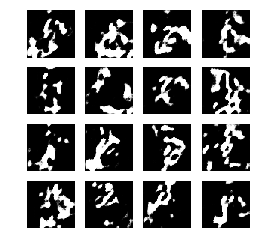

Time for epoch 1 is 90.71777939796448 sec


In [ ]:
%%time
train(train_dataset, EPOCHS)